In [1]:
# load labeled images and labels from the indexed directory and create a dataset for training and validation
import os

segdir = 'indexed'
segdir2 = 'auto_generated_images'
dataset_dir = 'datasets'
dataset_name = 'segplots'

images_dir = 'images'
labels_dir = 'labels'

train_name = 'train'
val_name = 'val'

os.makedirs(segdir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

# create the train directory for the images and labels
path_to_train_images = os.path.join(dataset_dir, dataset_name, images_dir, train_name)
path_to_train_labels = os.path.join(dataset_dir, dataset_name, labels_dir, train_name)
os.makedirs(path_to_train_images, exist_ok=True)
os.makedirs(path_to_train_labels, exist_ok=True)
path_to_val_images = os.path.join(dataset_dir, dataset_name, images_dir, val_name)
path_to_val_labels = os.path.join(dataset_dir, dataset_name, labels_dir, val_name)
os.makedirs(path_to_val_images, exist_ok=True)
os.makedirs(path_to_val_labels, exist_ok=True)

# clear the directories above before copying the files
to_clear = [path_to_train_images, path_to_train_labels, path_to_val_images, path_to_val_labels]
for directory in to_clear:
    for root, dirs, files in os.walk(directory):
        for file in files:
            os.remove(os.path.join(root, file))

import shutil
import numpy.random as npr


split_ratio = 0.85 # 85% of the data will be used for training
train_count = 0
val_count = 0

for seg in [segdir, segdir2]:
    for root, dirs, files in os.walk(seg):
        for file in files:
            if file == 'origin.png':
                image = os.path.join(root, file)
                basename = os.path.basename(root)
                rng = (hash(basename)) % 0x7FFFFFFF         # make sure the random result is consistent
                random_src = npr.RandomState(rng)
                # check if there is a file named 'yolo_seg.txt' as well
                seg_file = os.path.join(root, 'yolo_seg.txt')
                if os.path.exists(seg_file):
                    if random_src.rand() < split_ratio:
                        # copy the image to the dataset directory and rename it with root directory name
                        shutil.copy(image, os.path.join(path_to_train_images, basename + '.png'))
                        # copy the seg file to the dataset directory and rename it with root directory name
                        shutil.copy(seg_file, os.path.join(path_to_train_labels, basename + '.txt'))
                        # print(f'Copied {image} and {seg_file} to training directory')
                        train_count += 1
                    else:
                        # copy the image to the dataset directory and rename it with root directory name
                        shutil.copy(image, os.path.join(path_to_val_images, basename + '.png'))
                        # copy the seg file to the dataset directory and rename it with root directory name
                        shutil.copy(seg_file, os.path.join(path_to_val_labels, basename + '.txt'))
                        # print(f'Copied {image} and {seg_file} to validation directory')
                        val_count += 1

print(f'Copied {train_count} files to training directory')
print(f'Copied {val_count} files to validation directory')

Copied 145 files to training directory
Copied 30 files to validation directory


The dataset label format used for training YOLO segmentation models is as follows:

One text file per image: Each image in the dataset has a corresponding text file with the same name as the image file and the ".txt" extension.
One row per object: Each row in the text file corresponds to one object instance in the image.
Object information per row: Each row contains the following information about the object instance:
Object class index: An integer representing the class of the object (e.g., 0 for person, 1 for car, etc.).
Object bounding coordinates: The bounding coordinates around the mask area, normalized to be between 0 and 1.
The format for a single row in the segmentation dataset file is as follows:


<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
In this format, <class-index> is the index of the class for the object, and <x1> <y1> <x2> <y2> ... <xn> <yn> are the bounding coordinates of the object's segmentation mask. The coordinates are separated by spaces.

Here is an example of the YOLO dataset format for a single image with two objects made up of a 3-point segment and a 5-point segment.


0 0.681 0.485 0.670 0.487 0.676 0.487
1 0.504 0.000 0.501 0.004 0.498 0.004 0.493 0.010 0.492 0.0104

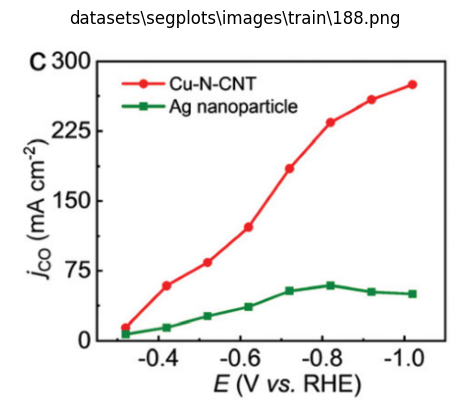

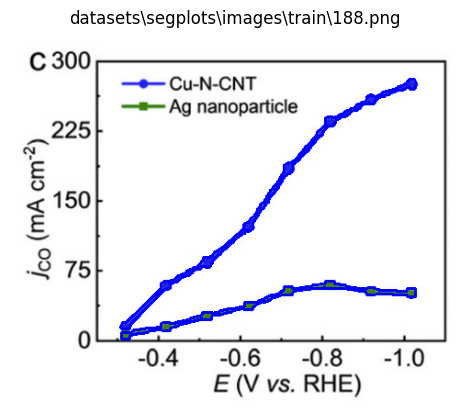

In [2]:
# loads and displays an image with the segmentation
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, seg_file):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(image)
    plt.axis('off')
    plt.show()

    with open(seg_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_index = int(parts[0])
            coordinates = list(map(float, parts[1:]))

            # Draw the segmentation mask
            points = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
            points = np.array(points) * [img.shape[1], img.shape[0]]  # Denormalize coordinates
            points = points.astype(np.int32)
            cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        plt.show()

import time
random_src = npr.RandomState(int(time.time()))

# display the first image with the segmentation
sample_index = random_src.randint(0, len(os.listdir(path_to_train_images)))
image = os.path.join(path_to_train_images, os.listdir(path_to_train_images)[sample_index])
seg_file = os.path.join(path_to_train_labels, os.listdir(path_to_train_labels)[sample_index])
display_image(image, seg_file)


In [ ]:
# load the training configuration and start training
from ultralytics import YOLO
from ultralytics.utils.metrics import SegmentMetrics
model = YOLO("models/yolo11n-seg.pt")  # load a pretrained model (recommended for training)

# Train the model
results: SegmentMetrics = model.train(data="segplots.yaml", epochs=47, imgsz=640)

Ultralytics 8.3.27  Python-3.11.0 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=segplots.yaml, epochs=47, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning F:\codes\pl\plot-labeling\datasets\segplots\labels\train... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 457.13it/s]

train: New cache created: F:\codes\pl\plot-labeling\datasets\segplots\labels\train.cache



val: Scanning F:\codes\pl\plot-labeling\datasets\segplots\labels\val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 472.21it/s]

val: New cache created: F:\codes\pl\plot-labeling\datasets\segplots\labels\val.cache


Plotting labels to runs\segment\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train4
Starting training for 47 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/47         0G      1.776       2.42      3.378      1.444        268        640: 100%|██████████| 9/9 [00:37<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all         20        203     0.0135      0.415      0.128     0.0743    0.00784      0.231     0.0771     0.0415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/47         0G      1.137      1.343      2.651      1.092        198        640: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

                   all         20        203     0.0212      0.629       0.38      0.237      0.018      0.529       0.28      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/47         0G      1.128      1.144      2.177      1.086        184        640: 100%|██████████| 9/9 [00:31<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

                   all         20        203     0.0198      0.588      0.328      0.209     0.0179      0.528      0.273      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/47         0G      1.233      1.084      1.756      1.104        157        640: 100%|██████████| 9/9 [00:32<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

                   all         20        203     0.0195      0.572      0.319      0.197     0.0159      0.468      0.229      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/47         0G       1.11     0.9735      1.442      1.082        159        640: 100%|██████████| 9/9 [00:33<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

                   all         20        203      0.824      0.152       0.35      0.225      0.685      0.087      0.248       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/47         0G      1.093     0.9355      1.285      1.082        143        640: 100%|██████████| 9/9 [00:32<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

                   all         20        203      0.732       0.19       0.28      0.171      0.335      0.165       0.13     0.0881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/47         0G      1.112     0.9941      1.195      1.079        206        640: 100%|██████████| 9/9 [00:36<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         20        203      0.534       0.13      0.205      0.153     0.0199      0.326      0.178      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/47         0G       1.03     0.9225      1.197      1.066        175        640: 100%|██████████| 9/9 [00:34<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

                   all         20        203      0.595      0.224      0.364      0.248       0.39      0.241      0.262      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/47         0G      1.041     0.9499      1.145      1.082        257        640: 100%|██████████| 9/9 [00:34<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all         20        203      0.554      0.421      0.453      0.323      0.488      0.286      0.351       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/47         0G      1.063     0.9354      1.086      1.052        222        640: 100%|██████████| 9/9 [00:34<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

                   all         20        203      0.576      0.492      0.487      0.366      0.508      0.403      0.403      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/47         0G       1.02     0.8889      1.042      1.047        237        640: 100%|██████████| 9/9 [00:34<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

                   all         20        203      0.699      0.528      0.546      0.416      0.603      0.443      0.449      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/47         0G      1.006     0.8673      1.038      1.034        310        640: 100%|██████████| 9/9 [00:34<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

                   all         20        203      0.642      0.588      0.548      0.409      0.565      0.491      0.457      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/47         0G      1.045     0.9332      1.093      1.038        228        640: 100%|██████████| 9/9 [00:32<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

                   all         20        203      0.701      0.634      0.595      0.392      0.561      0.516      0.477      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/47         0G      1.025     0.8685      1.035      1.051        349        640: 100%|██████████| 9/9 [00:32<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

                   all         20        203      0.689      0.607      0.618      0.447      0.505      0.497      0.407      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/47         0G      1.042     0.9214      1.051      1.068        163        640: 100%|██████████| 9/9 [00:32<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all         20        203      0.612      0.566      0.601      0.435      0.521      0.436      0.431      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/47         0G     0.9825     0.9262     0.9868      1.029        184        640: 100%|██████████| 9/9 [00:32<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

                   all         20        203      0.642      0.644      0.654      0.483      0.524      0.488      0.461      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/47         0G     0.9685     0.8484     0.9678      1.014        217        640: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

                   all         20        203      0.698      0.632      0.677      0.519      0.515      0.561      0.497       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/47         0G     0.9719     0.8258     0.9777       1.02        280        640: 100%|██████████| 9/9 [00:32<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

                   all         20        203      0.765      0.638      0.678      0.529      0.559      0.525      0.492      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/47         0G     0.9371      0.799     0.9149      1.003        213        640: 100%|██████████| 9/9 [00:31<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

                   all         20        203      0.758      0.634      0.697      0.536      0.631      0.545      0.541      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/47         0G      0.904     0.7875     0.9052      1.002        181        640: 100%|██████████| 9/9 [00:32<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         20        203      0.839      0.644       0.71      0.572      0.658      0.524      0.546      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/47         0G     0.8799       0.83     0.8845     0.9796        296        640: 100%|██████████| 9/9 [00:32<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         20        203       0.85      0.648      0.719      0.567      0.606      0.554      0.511      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/47         0G     0.9035     0.8511      0.896     0.9802        296        640: 100%|██████████| 9/9 [00:32<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

                   all         20        203      0.829      0.708      0.755      0.574      0.656      0.657      0.593       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/47         0G     0.8709     0.8405     0.8591     0.9873        294        640: 100%|██████████| 9/9 [00:32<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         20        203      0.814      0.739       0.77      0.587      0.664      0.602      0.592      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/47         0G     0.8546     0.8457     0.8436     0.9892        149        640: 100%|██████████| 9/9 [00:32<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all         20        203        0.8      0.749      0.776      0.601      0.686      0.568      0.586      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/47         0G      0.865     0.9141     0.8585     0.9912        193        640: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         20        203      0.784      0.676      0.724      0.571      0.629      0.693      0.608      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/47         0G     0.8507     0.7639     0.8751      0.982        222        640: 100%|██████████| 9/9 [00:31<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all         20        203      0.805      0.721      0.765      0.592      0.699      0.628      0.622      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/47         0G     0.8393     0.8166     0.8214     0.9644        254        640: 100%|██████████| 9/9 [00:32<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         20        203      0.835      0.683      0.774       0.61      0.699      0.643      0.638      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/47         0G     0.8512     0.8054     0.8176     0.9781        159        640: 100%|██████████| 9/9 [00:32<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         20        203      0.835      0.712      0.777      0.619       0.68      0.654      0.645      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/47         0G     0.8437     0.7908     0.8454      0.984        200        640: 100%|██████████| 9/9 [00:32<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         20        203      0.855      0.717      0.783      0.621      0.685      0.704      0.673      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/47         0G     0.8664     0.7926     0.8338     0.9747        211        640: 100%|██████████| 9/9 [00:31<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

                   all         20        203      0.866      0.687      0.776      0.602      0.719      0.644      0.661      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/47         0G     0.8544      0.836     0.8091     0.9739        237        640: 100%|██████████| 9/9 [00:32<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         20        203      0.805      0.748      0.783      0.612      0.774      0.626      0.653      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/47         0G     0.8164     0.7099     0.7824     0.9609        220        640: 100%|██████████| 9/9 [00:32<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         20        203      0.857       0.77      0.793       0.64      0.745      0.664      0.677      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/47         0G     0.8078     0.7777     0.7597     0.9572        230        640: 100%|██████████| 9/9 [00:32<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

                   all         20        203      0.841      0.759      0.791       0.64      0.764      0.672      0.693      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/47         0G     0.7685     0.7886     0.7362     0.9432        170        640: 100%|██████████| 9/9 [00:32<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all         20        203      0.831      0.749       0.79      0.629      0.702      0.706      0.689      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/47         0G     0.7716     0.6938      0.754     0.9477        209        640: 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         20        203      0.849      0.758      0.797      0.635      0.701      0.752      0.712      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/47         0G     0.7917     0.8118     0.7862     0.9503        269        640: 100%|██████████| 9/9 [00:32<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all         20        203      0.833      0.732      0.782      0.631      0.743      0.646      0.669      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/47         0G     0.7978     0.7413     0.7397      0.934        208        640: 100%|██████████| 9/9 [00:32<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

                   all         20        203      0.855      0.712      0.779      0.622      0.719      0.682      0.664       0.38


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/47         0G     0.7453     0.6447     0.8288     0.9509        132        640: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

                   all         20        203      0.883      0.693      0.768       0.63      0.785       0.61      0.668      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/47         0G     0.7365     0.7068     0.7726     0.9312         94        640: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         20        203      0.878      0.697      0.767      0.621      0.782      0.625      0.668      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/47         0G      0.709     0.6346     0.7564     0.9364        133        640: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         20        203      0.843       0.73      0.776      0.619      0.767      0.661      0.673      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/47         0G     0.6866     0.6095     0.7476     0.9236         87        640: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all         20        203       0.83      0.741      0.785      0.625      0.749      0.693      0.694      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/47         0G       0.71     0.6178     0.7525     0.9352        133        640: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all         20        203      0.815      0.775      0.806      0.644      0.735       0.72      0.703      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/47         0G     0.7127     0.6708     0.7583     0.9427        182        640: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

                   all         20        203       0.84      0.778      0.821      0.654      0.745      0.731       0.72      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/47         0G     0.6865     0.6724     0.7406     0.9237         61        640: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         20        203      0.856      0.768      0.823      0.657       0.75      0.726      0.726      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/47         0G     0.6819     0.5825     0.7263     0.9252        118        640: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

                   all         20        203      0.869       0.76      0.822      0.658      0.767      0.713      0.736      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/47         0G      0.681     0.6573     0.7104      0.915         80        640: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         20        203      0.856      0.783      0.825      0.664      0.775      0.708      0.722      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/47         0G     0.6368     0.5404     0.7007     0.9153         63        640: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         20        203      0.856      0.784      0.813      0.663      0.774      0.715      0.719      0.419



47 epochs completed in 0.461 hours.
Optimizer stripped from runs\segment\train4\weights\last.pt, 6.0MB
Optimizer stripped from runs\segment\train4\weights\best.pt, 6.0MB

Validating runs\segment\train4\weights\best.pt...
Ultralytics 8.3.27  Python-3.11.0 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
YOLO11n-seg summary (fused): 265 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


                   all         20        203      0.856      0.784      0.813      0.663      0.776       0.71      0.714      0.419
                  line         14         92      0.722      0.706      0.723      0.549      0.572      0.565      0.544       0.24
                   bar          6        111       0.99      0.862      0.903      0.777      0.979      0.855      0.884      0.598
Speed: 0.6ms preprocess, 52.3ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs\segment\train4
